In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-tabnet


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.7 MB/s eta 0:00:00


In [ ]:
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled


Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9626690	test: 1.1061311	best: 1.1061311 (0)	total: 47.9ms	remaining: 5m 34s
100:	learn: 0.1516714	test: 0.2257944	best: 0.2257944 (100)	total: 4.22s	remaining: 4m 48s
200:	learn: 0.1029220	test: 0.2008029	best: 0.2007551 (199)	total: 7.12s	remaining: 4m
300:	learn: 0.0695720	test: 0.1868625	best: 0.1868625 (300)	total: 13.4s	remaining: 4m 57s
400:	learn: 0.0484343	test: 0.1817658	best: 0.1817658 (400)	total: 19.4s	remaining: 5m 18s
500:	learn: 0.0371439	test: 0.1800920	best: 0.1800920 (500)	total: 23.8s	remaining: 5m 9s
600:	learn: 0.0294355	test: 0.1793306	best: 0.1793281 (599)	total: 30.2s	remaining: 5m 21s
700:	learn: 0.0242490	test: 0.1787308	best: 0.1787206 (696)	total: 34.8s	remaining: 5m 12s
800:	learn: 0.0200455	test: 0.1783699	best: 0.1783699 (800)	total: 40.1s	remaining: 5m 10s
900:	learn: 0.0168766	test: 0.1781988	best: 0.1781988 (900)	total: 45.9s	remaining: 5m 10s
1000:	learn: 0.0146875	test: 0.17813

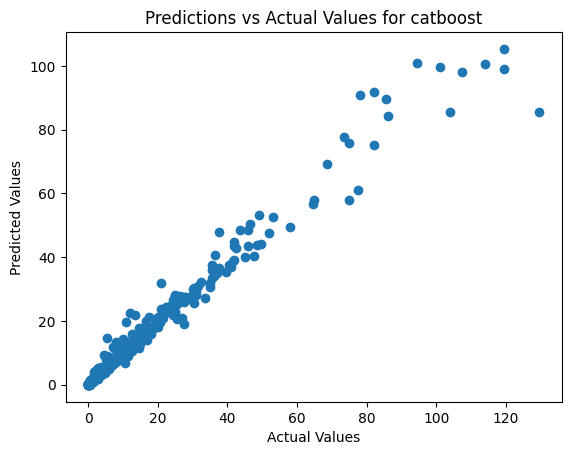

In [ ]:
#In this Cell we present the first run of catboost on the "player vmarket value" prediction before hyper-parameters tuning with Optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
import torch

def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy


def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
    #if model_name == 'TabNet
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=500,
            patience=5,
            batch_size=1024
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.05)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    for model_name in ['catboost']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('value_eur_2022')


In [ ]:
#In this cell we use Optuna to fine tune the model Hyper Parameters
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
numeric_features = df.drop(columns=['value_eur_2022'])
target = df['value_eur_2022']

    # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'iterations': trial.suggest_int('iterations', 4000, 5000),
        'depth': trial.suggest_int('depth', 10, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3)

    }

    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    # Make predictions and calculate the mean absolute error
    y_pred = model.predict(X_test)
    score = mean_absolute_error(y_test, y_pred)
    return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-08-14 19:25:55,632] A new study created in memory with name: no-name-7fcba251-b27f-4a20-b839-36522e0b661a
<ipython-input-31-1f13dae4550e>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-08-14 19:39:55,906] Trial 0 finished with value: 0.44452514963094114 and parameters: {'iterations': 4445, 'depth': 12, 'learning_rate': 0.015348849414642799}. Best is trial 0 with value: 0.44452514963094114.
<ipython-input-31-1f13dae4550e>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-08-14 19:46:58,003] Trial 1 finish

Best hyperparameters:  {'iterations': 4711, 'depth': 10, 'learning_rate': 0.011068343164856548}


<ipython-input-4-03fd995a8725>:66: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-3-d5cc0dd32cd6>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9922873	test: 1.1413767	best: 1.1413767 (0)	total: 220ms	remaining: 25m 42s
100:	learn: 0.4775237	test: 0.5649086	best: 0.5649086 (100)	total: 20.5s	remaining: 23m 20s
200:	learn: 0.2600860	test: 0.3179906	best: 0.3179906 (200)	total: 38.9s	remaining: 21m 54s
300:	learn: 0.1712540	test: 0.2286102	best: 0.2286102 (300)	total: 57.2s	remaining: 21m 11s
400:	learn: 0.1319015	test: 0.1984773	best: 0.1984773 (400)	total: 1m 14s	remaining: 20m 30s
500:	learn: 0.1141892	test: 0.1863406	best: 0.1863406 (500)	total: 1m 27s	remaining: 18m 57s
600:	learn: 0.1014970	test: 0.1763372	best: 0.1763372 (600)	total: 1m 40s	remaining: 17m 50s
700:	learn: 0.0916065	test: 0.1686828	best: 0.1686828 (700)	total: 1m 54s	remaining: 17m 5s
800:	learn: 0.0837697	test: 0.1625802	best: 0.1625802 (800)	total: 2m 9s	remaining: 16m 39s
900:	learn: 0.0778710	test: 0.1579217	best: 0.1579194 (899)	total: 2m 27s	remaining: 16m 38s
1000:	learn: 0.072

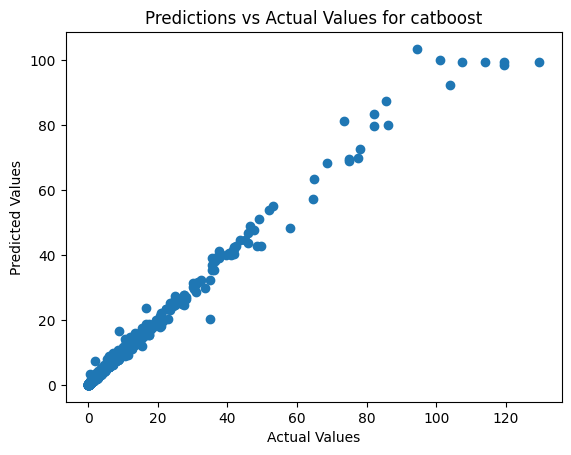

In [ ]:
#In this cell we see the improvemnt of the model with better hyper-parameters for market value

import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        df_filtered = df


        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor

from catboost import CatBoostRegressor
import torch

def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is (1 - custom_accuracy).
    """
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate the percentage difference
    percentage_diff = torch.abs((y_true - y_pred) / y_true)

    # Calculate accuracy (percentage difference within 10%)
    accuracy = torch.mean((percentage_diff <= 0.1).float())

    # Return the loss as 1 - accuracy (since accuracy is the metric we want to maximize)
    loss = 1 - accuracy

    return loss

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=500,
            patience=5,
            batch_size=1024
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.01)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    for model_name in ['catboost']:
    #for model_name in ['TabNet', 'MLP', 'XGBoost', TabNet_pretrain]:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('value_eur_2022')


<ipython-input-17-5a37e7b8365c>:66: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-3-d5cc0dd32cd6>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating TabNet with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.99336 |  0:00:00s
epoch 1  | loss: 0.99662 |  0:00:01s
epoch 2  | loss: 0.99441 |  0:00:01s
epoch 3  | loss: 0.99343 |  0:00:02s
epoch 4  | loss: 0.99477 |  0:00:02s
epoch 5  | loss: 0.99574 |  0:00:03s
epoch 6  | loss: 0.99501 |  0:00:03s
epoch 7  | loss: 0.99525 |  0:00:04s
epoch 8  | loss: 0.9944  |  0:00:04s
epoch 9  | loss: 0.99378 |  0:00:05s
epoch 10 | loss: 0.99537 |  0:00:06s
epoch 11 | loss: 0.9933  |  0:00:06s
epoch 12 | loss: 0.99415 |  0:00:07s
epoch 13 | loss: 0.99451 |  0:00:08s
epoch 14 | loss: 0.99549 |  0:00:08s
epoch 15 | loss: 0.99549 |  0:00:09s
epoch 16 | loss: 0.99403 |  0:00:09s
epoch 17 | loss: 0.99402 |  0:00:10s
epoch 18 | loss: 0.99537 |  0:00:10s
epoch 19 | loss: 0.99451 |  0:00:11s
epoch 20 | loss: 0.99305 |  0:00:11s
epoch 21 | loss: 0.99256 |  0:00:11s
epoch 22 | loss: 0.99207 |  0:00:12s
epoch 23 | loss: 0.99256 |  0:00:12s
epoch 24 | loss: 0.99366 |  0:00:13s
epoch 25 | loss: 0.99475 |  0:00:13s
epoch 26 | loss: 0.99341 |  0:00:14s
e

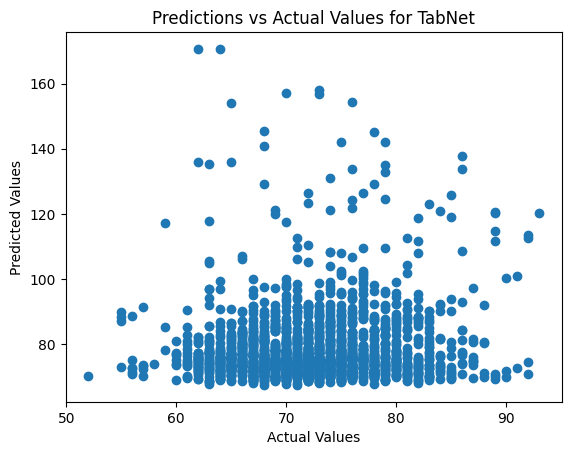

Training and evaluating Stacked with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5_precent_accuracy for Stacked: 0.9218825812712276


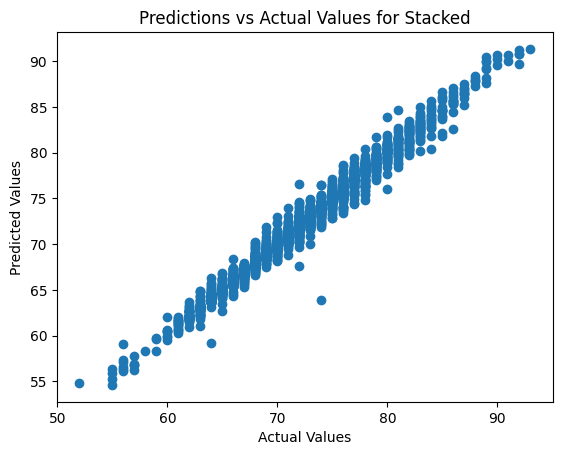

Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9576006	test: 0.9643684	best: 0.9643684 (0)	total: 48.7ms	remaining: 5m 40s
100:	learn: 0.1733004	test: 0.1821063	best: 0.1821063 (100)	total: 4.62s	remaining: 5m 15s
200:	learn: 0.1393488	test: 0.1582263	best: 0.1582261 (199)	total: 9.51s	remaining: 5m 21s
300:	learn: 0.1188339	test: 0.1487616	best: 0.1487616 (300)	total: 15.4s	remaining: 5m 43s
400:	learn: 0.1051089	test: 0.1455899	best: 0.1455899 (400)	total: 20s	remaining: 5m 28s
500:	learn: 0.0929813	test: 0.1434223	best: 0.1434160 (499)	total: 26.2s	remaining: 5m 40s
600:	learn: 0.0834098	test: 0.1420408	best: 0.1420408 (600)	total: 30.8s	remaining: 5m 28s
700:	learn: 0.0747173	test: 0.1410799	best: 0.1410793 (698)	total: 35.3s	remaining: 5m 17s
800:	learn: 0.0672478	test: 0.1404127	best: 0.1404096 (797)	total: 41.7s	remaining: 5m 22s
900:	learn: 0.0608911	test: 0.1399602	best: 0.1399602 (900)	total: 46.2s	remaining: 5m 12s
1000:	learn: 0.0545527	test: 0.13

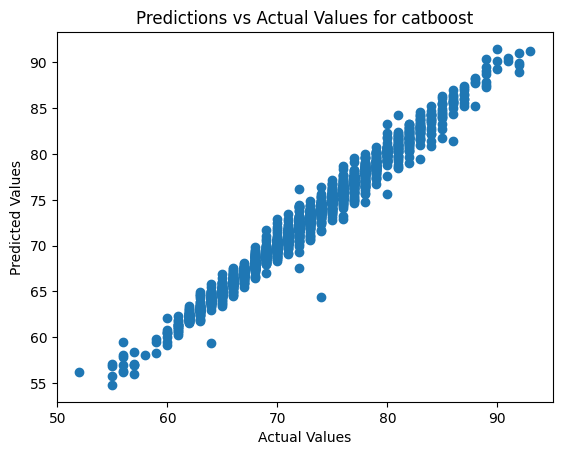

In [ ]:
#In this cell we can see the comparison between different models for potential
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000




from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch

def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.02)

    return accuracy
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is (1 - custom_accuracy).
    """
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate the percentage difference
    percentage_diff = torch.abs((y_true - y_pred) / y_true)

    # Calculate accuracy (percentage difference within 10%)
    accuracy = torch.mean((percentage_diff <= 0.02).float())

    # Return the loss as 1 - accuracy (since accuracy is the metric we want to maximize)
    loss = 1 - accuracy

    return loss

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=300,
            patience=5,
            batch_size=1024,
            loss_fn=custom_loss  # Use the custom loss function
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.05)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    for model_name in ['TabNet', 'Stacked', 'catboost']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('potential_2022')


<ipython-input-4-d5cc0dd32cd6>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating TabNet with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.95569 |  0:00:00s
epoch 1  | loss: 0.95641 |  0:00:01s
epoch 2  | loss: 0.96128 |  0:00:01s
epoch 3  | loss: 0.96737 |  0:00:02s
epoch 4  | loss: 0.95856 |  0:00:02s
epoch 5  | loss: 0.96367 |  0:00:03s
epoch 6  | loss: 0.95927 |  0:00:03s
epoch 7  | loss: 0.96463 |  0:00:04s
epoch 8  | loss: 0.96609 |  0:00:04s
epoch 9  | loss: 0.96999 |  0:00:05s
epoch 10 | loss: 0.96315 |  0:00:06s
epoch 11 | loss: 0.96193 |  0:00:06s
epoch 12 | loss: 0.96803 |  0:00:07s
epoch 13 | loss: 0.96901 |  0:00:08s
epoch 14 | loss: 0.96827 |  0:00:08s
epoch 15 | loss: 0.97023 |  0:00:09s
epoch 16 | loss: 0.97047 |  0:00:10s
epoch 17 | loss: 0.97169 |  0:00:11s
epoch 18 | loss: 0.9712  |  0:00:11s
epoch 19 | loss: 0.97486 |  0:00:12s
epoch 20 | loss: 0.96754 |  0:00:13s
epoch 21 | loss: 0.97242 |  0:00:13s
epoch 22 | loss: 0.97095 |  0:00:14s
epoch 23 | loss: 0.9734  |  0:00:14s
epoch 24 | loss: 0.97193 |  0:00:15s
epoch 25 | loss: 0.9734  |  0:00:15s
epoch 26 | loss: 0.96802 |  0:00:16s
e

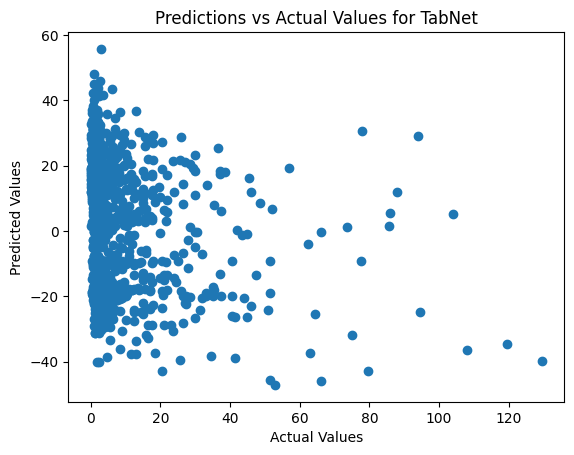

Training and evaluating Stacked with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5_precent_accuracy for Stacked: 0.653635652853792


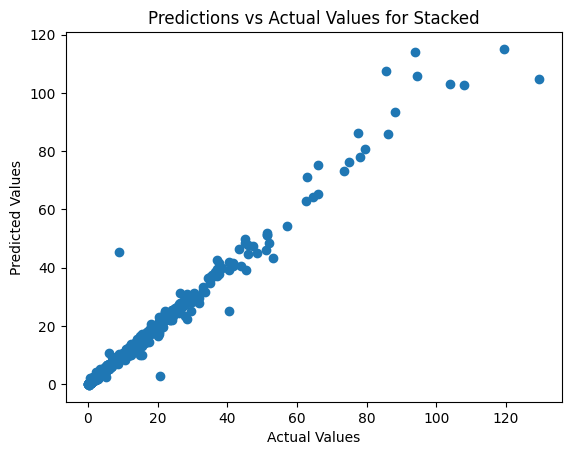

Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9929810	test: 1.1117354	best: 1.1117354 (0)	total: 255ms	remaining: 29m 44s
100:	learn: 0.4916004	test: 0.5524453	best: 0.5524453 (100)	total: 19.5s	remaining: 22m 14s
200:	learn: 0.2692332	test: 0.3117011	best: 0.3117011 (200)	total: 36.5s	remaining: 20m 35s
300:	learn: 0.1752020	test: 0.2249547	best: 0.2249547 (300)	total: 55.6s	remaining: 20m 37s
400:	learn: 0.1309759	test: 0.1963262	best: 0.1963262 (400)	total: 1m 13s	remaining: 20m 10s
500:	learn: 0.1085795	test: 0.1827326	best: 0.1827326 (500)	total: 1m 27s	remaining: 18m 53s
600:	learn: 0.0960990	test: 0.1761483	best: 0.1761483 (600)	total: 1m 40s	remaining: 17m 46s
700:	learn: 0.0866263	test: 0.1711886	best: 0.1711886 (700)	total: 1m 53s	remaining: 16m 58s
800:	learn: 0.0791777	test: 0.1668605	best: 0.1668605 (800)	total: 2m 7s	remaining: 16m 24s
900:	learn: 0.0722341	test: 0.1628512	best: 0.1628512 (900)	total: 2m 21s	remaining: 15m 54s
1000:	learn: 0.06

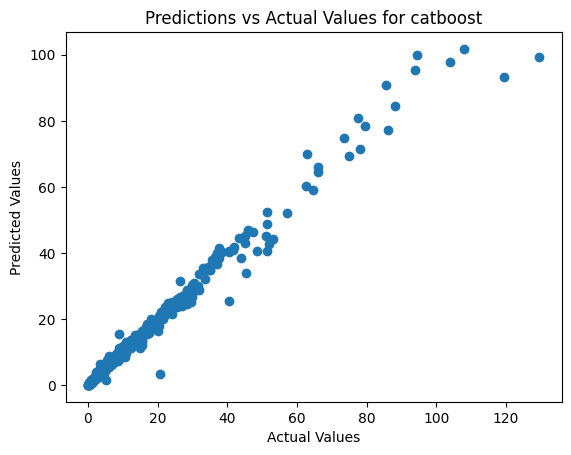

In [ ]:
#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        df_filtered = df
        #df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is (1 - custom_accuracy).
    """
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate the percentage difference
    percentage_diff = torch.abs((y_true - y_pred) / y_true)

    # Calculate accuracy (percentage difference within 10%)
    accuracy = torch.mean((percentage_diff <= 0.1).float())

    # Return the loss as 1 - accuracy (since accuracy is the metric we want to maximize)
    loss = 1 - accuracy

    return loss

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
    #if model_name == 'TabNet
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=300,
            patience=5,
            batch_size=1024,
            loss_fn=custom_loss  # Use the custom loss function
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.01)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    for model_name in ['TabNet', 'Stacked', 'catboost']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('value_eur_2022')


<ipython-input-48-087284a34c13>:114: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-48-087284a34c13>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating ImprovedMLP with best hyperparameters...
Epoch [10/500], Loss: 0.3667
Epoch [20/500], Loss: 0.2733
Epoch [30/500], Loss: 0.2362
Epoch [40/500], Loss: 0.2034
Epoch [50/500], Loss: 0.1740
Epoch [60/500], Loss: 0.1562
Epoch [70/500], Loss: 0.1426
Epoch [80/500], Loss: 0.1253
Epoch [90/500], Loss: 0.1233
Epoch [100/500], Loss: 0.1129
Epoch [110/500], Loss: 0.1102
Epoch [120/500], Loss: 0.1098
Epoch [130/500], Loss: 0.1069
Epoch [140/500], Loss: 0.0998
Epoch [150/500], Loss: 0.1031
Epoch [160/500], Loss: 0.1003
Epoch [170/500], Loss: 0.0982
Epoch [180/500], Loss: 0.0954
Epoch [190/500], Loss: 0.0919
Epoch [200/500], Loss: 0.0893
Epoch [210/500], Loss: 0.0881
Epoch [220/500], Loss: 0.0878
Epoch [230/500], Loss: 0.0871
Epoch [240/500], Loss: 0.0850
Epoch [250/500], Loss: 0.0850
Epoch [260/500], Loss: 0.0827
Epoch [270/500], Loss: 0.0833
Epoch [280/500], Loss: 0.0815
Epoch [290/500], Loss: 0.0839
Epoch [300/500], Loss: 0.0831
Epoch [310/500], Loss: 0.0804
Epoch [320/500

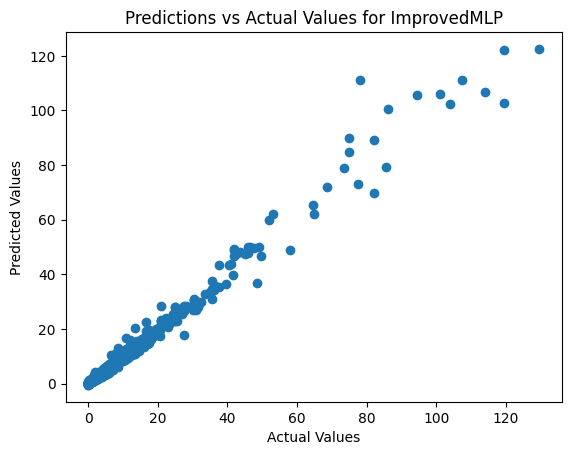

In [ ]:
#Finding the best MLP Architecture:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=256, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=256, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(AdvancedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3):
        super(ImprovedMLP, self).__init__()

        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LeakyReLU())  # LeakyReLU for improved performance
            layers.append(nn.BatchNorm1d(hidden_dim))  # Batch Normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is 1 - accuracy (custom_accuracy).
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    percentage_diff = torch.abs((y_true - y_pred) / y_true)
    accuracy = torch.mean((percentage_diff <= 0.05).float())
    loss = 1 - accuracy

    return loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        # Calculate MSE loss
        mse_loss = nn.MSELoss(reduction='none')(y_pred, y_true)
        # Apply weights
        weighted_loss = mse_loss * self.weights
        return weighted_loss.mean()



def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'ImprovedMLP':
        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Initialize the model
        input_dim = X_train.shape[1]
        model = ImprovedMLP(input_dim)

        # Define the custom loss function and optimizer
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        # Example usage
        #print(y_train.flatten())
        weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train.flatten()])  # Example weights
        #criterion = WeightedMSELoss(weights)
        # Training loop
        epochs = 500
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_scaled = y_pred_tensor.numpy()

        y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

        # Compute custom accuracy
        five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
        print(f'5_percent_accuracy for {model_name}: {five_percent_accuracy}')

        # Plot the predicted vs. actual values
        plt.scatter(y_test_original, y_pred)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predictions vs Actual Values for {model_name}')
        plt.show()

    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_params
    # Default best parameters
    best_params = {
        'ImprovedMLP': {
            # Define any best parameters here if needed
        }
    }
    best_params = study.best_params

    # Training and evaluation
    for model_name in ['ImprovedMLP']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params.get(model_name, {}), target_scaler)

fifa_pred('value_eur_2022')




In [ ]:
#Finding the best MLP Architecture:

import optuna
import torch
import torch.nn as nn
import torch.optim as optim

def objective(trial):
    numeric_features = df.drop(columns=['value_eur_2022'])
    target = df['value_eur_2022']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    # Define the hyperparameters to be tuned
    hidden_dim0 = trial.suggest_int('hidden_dim0', 128, 512)
    hidden_dim1 = trial.suggest_int('hidden_dim1', 64, 256)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 32, 128)
    hidden_dim3 = trial.suggest_int('hidden_dim3', 16, 64)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)

    # Initialize the model with the suggested hyperparameters
    model = ImprovedMLP(
        input_dim=X_train_scaled.shape[1],
        hidden_dims=[hidden_dim0, hidden_dim1, hidden_dim2, hidden_dim3],
        dropout_rate=dropout_rate
    )

    # Define the loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    epochs = 100  # Reduced for quicker optimization
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train_scaled, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(y_train_scaled, dtype=torch.float32))
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(torch.tensor(X_test_scaled, dtype=torch.float32))
        y_pred_scaled = y_pred_tensor.numpy()

    y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_original = target_scaler.inverse_transform(y_test_scaled).flatten()

    # Compute custom accuracy
    accuracy = custom_accuracy(y_test_original, y_pred)
    return 1 - accuracy  # Optuna minimizes the objective function, so we return 1 - accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:")
print(study.best_params)
print("Best value:")
print(study.best_value)


[I 2024-08-20 14:43:31,793] A new study created in memory with name: no-name-f00ea785-8782-40c5-ad0e-4e48d0cf9571
<ipython-input-53-38699b6f4ec2>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-53-38699b6f4ec2>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-53-38699b6f4ec2>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e

Best hyperparameters:
{'hidden_dim0': 490, 'hidden_dim1': 130, 'hidden_dim2': 39, 'hidden_dim3': 30, 'dropout_rate': 0.27893183390692483, 'lr': 0.018575820704433574, 'weight_decay': 6.805893037952561e-05}
Best value:
0.50509461426492


<ipython-input-73-51463125294e>:114: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-73-51463125294e>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating ImprovedMLP with best hyperparameters...
32
Epoch [100/2500], Loss: 0.0822
Epoch [200/2500], Loss: 0.0675
Epoch [300/2500], Loss: 0.0638
Epoch [400/2500], Loss: 0.0597
Epoch [500/2500], Loss: 0.0532
Epoch [600/2500], Loss: 0.0556
Epoch [700/2500], Loss: 0.0506
Epoch [800/2500], Loss: 0.0537
Epoch [900/2500], Loss: 0.0520
Epoch [1000/2500], Loss: 0.0512
Epoch [1100/2500], Loss: 0.0509
Epoch [1200/2500], Loss: 0.0480
Epoch [1300/2500], Loss: 0.0475
Epoch [1400/2500], Loss: 0.0464
Epoch [1500/2500], Loss: 0.0455
Epoch [1600/2500], Loss: 0.0483
Epoch [1700/2500], Loss: 0.0465
Epoch [1800/2500], Loss: 0.0466
Epoch [1900/2500], Loss: 0.0529
Epoch [2000/2500], Loss: 0.0436
Epoch [2100/2500], Loss: 0.0418
Epoch [2200/2500], Loss: 0.0436
Epoch [2300/2500], Loss: 0.0458
Epoch [2400/2500], Loss: 0.0420
Epoch [2500/2500], Loss: 0.0446
5_percent_accuracy for ImprovedMLP: 0.6380397865114023


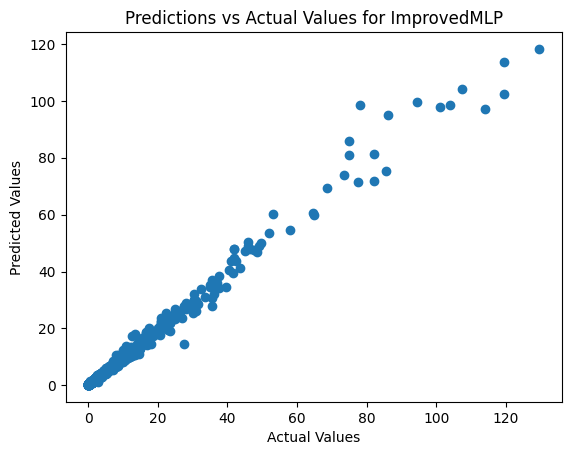

In [ ]:
#Finding the best MLP Architecture:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=490, hidden_dim1=130, hidden_dim2=39, hidden_dim3=30, dropout_rate=0.28):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=256, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(AdvancedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.27):
        super(ImprovedMLP, self).__init__()

        print(input_dim)
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LeakyReLU())  # LeakyReLU for improved performance
            layers.append(nn.BatchNorm1d(hidden_dim))  # Batch Normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is 1 - accuracy (custom_accuracy).
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    percentage_diff = torch.abs((y_true - y_pred) / y_true)
    accuracy = torch.mean((percentage_diff <= 0.05).float())
    loss = 1 - accuracy

    return loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        # Calculate MSE loss
        mse_loss = nn.MSELoss(reduction='none')(y_pred, y_true)
        # Apply weights
        weighted_loss = mse_loss * self.weights
        return weighted_loss.mean()



def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler,weights):
    if model_name == 'ImprovedMLP':
        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Initialize the model
        input_dim = X_train.shape[1]
        model = ImprovedMLP(input_dim)

        # Define the custom loss function and optimizer
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=7e-5)
        # Example usage
        #print(y_train.flatten())
        #weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train.flatten()])  # Example weights
        #criterion = WeightedMSELoss(weights)
        # Training loop
        epochs = 2500
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_scaled = y_pred_tensor.numpy()

        y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

        # Compute custom accuracy
        five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
        print(f'5_percent_accuracy for {model_name}: {five_percent_accuracy}')

        # Plot the predicted vs. actual values
        plt.scatter(y_test_original, y_pred)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predictions vs Actual Values for {model_name}')
        plt.show()

    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    #study = optuna.create_study(direction='minimize')
    #study.optimize(objective, n_trials=50)
    #best_params = study.best_params
    # Default best parameters
    best_params = {
        'ImprovedMLP': {
            # Define any best parameters here if needed
        }
    }
    #best_params = study.best_params
    weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train])  # Example weights

    # Training and evaluation
    for model_name in ['ImprovedMLP']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params.get(model_name, {}), target_scaler,weights)

fifa_pred('value_eur_2022')




<ipython-input-74-5a257565c6a5>:114: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-74-5a257565c6a5>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating ImprovedMLP with best hyperparameters...
32
Epoch [100/3500], Loss: 0.0791
Epoch [200/3500], Loss: 0.0655
Epoch [300/3500], Loss: 0.0590
Epoch [400/3500], Loss: 0.0621
Epoch [500/3500], Loss: 0.0533
Epoch [600/3500], Loss: 0.0530
Epoch [700/3500], Loss: 0.0508
Epoch [800/3500], Loss: 0.0505
Epoch [900/3500], Loss: 0.0519
Epoch [1000/3500], Loss: 0.0498
Epoch [1100/3500], Loss: 0.0469
Epoch [1200/3500], Loss: 0.0472
Epoch [1300/3500], Loss: 0.0510
Epoch [1400/3500], Loss: 0.0474
Epoch [1500/3500], Loss: 0.0444
Epoch [1600/3500], Loss: 0.0482
Epoch [1700/3500], Loss: 0.0479
Epoch [1800/3500], Loss: 0.0452
Epoch [1900/3500], Loss: 0.0443
Epoch [2000/3500], Loss: 0.0435
Epoch [2100/3500], Loss: 0.0437
Epoch [2200/3500], Loss: 0.0431
Epoch [2300/3500], Loss: 0.0449
Epoch [2400/3500], Loss: 0.0437
Epoch [2500/3500], Loss: 0.0439
Epoch [2600/3500], Loss: 0.0436
Epoch [2700/3500], Loss: 0.0427
Epoch [2800/3500], Loss: 0.0450
Epoch [2900/3500], Loss: 0.0417
Epoch [3000/3

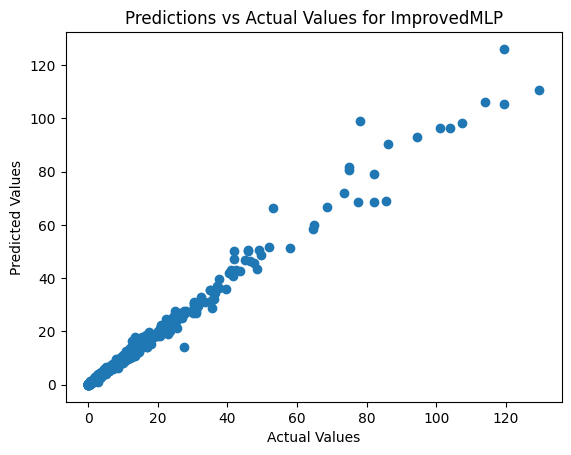

In [ ]:
#Finding the best MLP Architecture:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=490, hidden_dim1=130, hidden_dim2=39, hidden_dim3=30, dropout_rate=0.28):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=256, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(AdvancedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.27):
        super(ImprovedMLP, self).__init__()

        print(input_dim)
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LeakyReLU())  # LeakyReLU for improved performance
            layers.append(nn.BatchNorm1d(hidden_dim))  # Batch Normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is 1 - accuracy (custom_accuracy).
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    percentage_diff = torch.abs((y_true - y_pred) / y_true)
    accuracy = torch.mean((percentage_diff <= 0.05).float())
    loss = 1 - accuracy

    return loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        # Calculate MSE loss
        mse_loss = nn.MSELoss(reduction='none')(y_pred, y_true)
        # Apply weights
        weighted_loss = mse_loss * self.weights
        return weighted_loss.mean()



def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler,weights):
    if model_name == 'ImprovedMLP':
        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Initialize the model
        input_dim = X_train.shape[1]
        model = ImprovedMLP(input_dim)

        # Define the custom loss function and optimizer
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=7e-5)
        # Example usage
        #print(y_train.flatten())
        #weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train.flatten()])  # Example weights
        #criterion = WeightedMSELoss(weights)
        # Training loop
        epochs = 3500
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_scaled = y_pred_tensor.numpy()

        y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

        # Compute custom accuracy
        five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
        print(f'5_percent_accuracy for {model_name}: {five_percent_accuracy}')

        # Plot the predicted vs. actual values
        plt.scatter(y_test_original, y_pred)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predictions vs Actual Values for {model_name}')
        plt.show()

    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    #study = optuna.create_study(direction='minimize')
    #study.optimize(objective, n_trials=50)
    #best_params = study.best_params
    # Default best parameters
    best_params = {
        'ImprovedMLP': {
            # Define any best parameters here if needed
        }
    }
    #best_params = study.best_params
    weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train])  # Example weights

    # Training and evaluation
    for model_name in ['ImprovedMLP']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params.get(model_name, {}), target_scaler,weights)

fifa_pred('value_eur_2022')




<ipython-input-75-7e67ebf1d4a6>:114: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-75-7e67ebf1d4a6>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating ImprovedMLP with best hyperparameters...
32
Epoch [100/3500], Training Loss: 0.0839, Test Loss: 0.0652
Epoch [200/3500], Training Loss: 0.0676, Test Loss: 0.0524
Epoch [300/3500], Training Loss: 0.0630, Test Loss: 0.0476
Epoch [400/3500], Training Loss: 0.0565, Test Loss: 0.0424
Epoch [500/3500], Training Loss: 0.0581, Test Loss: 0.0429
Epoch [600/3500], Training Loss: 0.0580, Test Loss: 0.0397
Epoch [700/3500], Training Loss: 0.0568, Test Loss: 0.0412
Epoch [800/3500], Training Loss: 0.0518, Test Loss: 0.0394
Epoch [900/3500], Training Loss: 0.0532, Test Loss: 0.0441
Epoch [1000/3500], Training Loss: 0.0526, Test Loss: 0.0410
Epoch [1100/3500], Training Loss: 0.0490, Test Loss: 0.0460
Epoch [1200/3500], Training Loss: 0.0499, Test Loss: 0.0366
Epoch [1300/3500], Training Loss: 0.0489, Test Loss: 0.0416
Epoch [1400/3500], Training Loss: 0.0489, Test Loss: 0.0371
Epoch [1500/3500], Training Loss: 0.0490, Test Loss: 0.0410
Epoch [1600/3500], Training Loss: 0.0492,

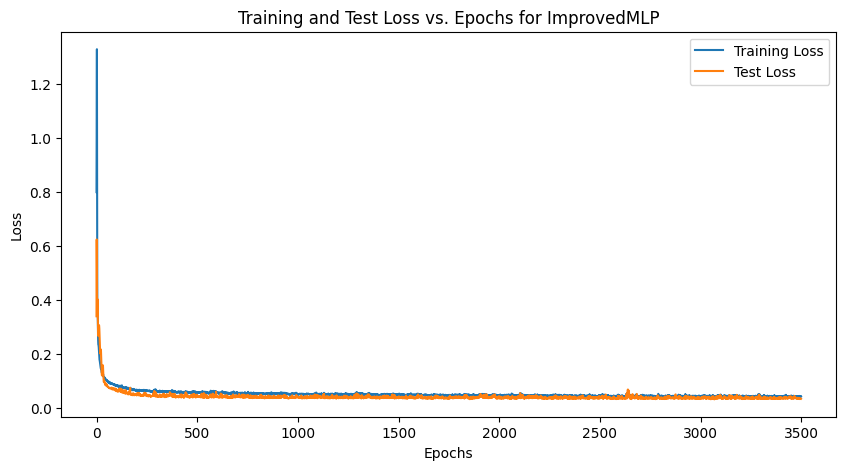

5_percent_accuracy for ImprovedMLP: 0.6826783114992722


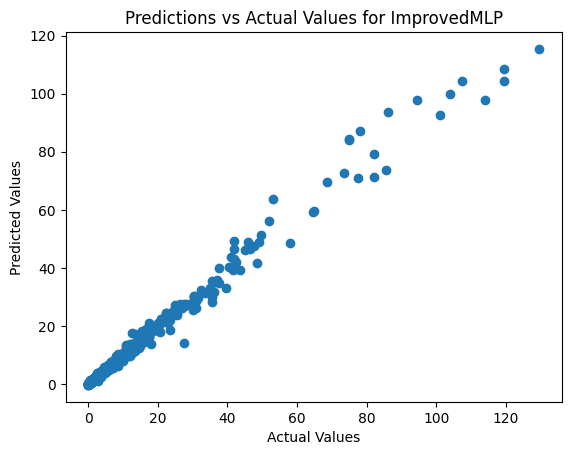

In [ ]:
#Finding the best MLP Architecture:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=490, hidden_dim1=130, hidden_dim2=39, hidden_dim3=30, dropout_rate=0.28):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=256, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(AdvancedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.27):
        super(ImprovedMLP, self).__init__()

        print(input_dim)
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LeakyReLU())  # LeakyReLU for improved performance
            layers.append(nn.BatchNorm1d(hidden_dim))  # Batch Normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is 1 - accuracy (custom_accuracy).
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    percentage_diff = torch.abs((y_true - y_pred) / y_true)
    accuracy = torch.mean((percentage_diff <= 0.05).float())
    loss = 1 - accuracy

    return loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        # Calculate MSE loss
        mse_loss = nn.MSELoss(reduction='none')(y_pred, y_true)
        # Apply weights
        weighted_loss = mse_loss * self.weights
        return weighted_loss.mean()


def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler, weights):
    if model_name == 'ImprovedMLP':
        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Initialize the model
        input_dim = X_train.shape[1]
        model = ImprovedMLP(input_dim)

        # Define the custom loss function and optimizer
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=7e-5)

        # To store losses
        train_losses = []
        test_losses = []

        # Training loop
        epochs = 3500
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            train_loss = criterion(outputs, y_train_tensor)
            train_loss.backward()
            optimizer.step()

            # Save the training loss
            train_losses.append(train_loss.item())

            # Evaluation step
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs, y_test_tensor)
                test_losses.append(test_loss.item())

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

        # Plot training and test loss vs. epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Test Loss vs. Epochs for {model_name}')
        plt.legend()
        plt.show()

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_scaled = y_pred_tensor.numpy()

        y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

        # Compute custom accuracy
        five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
        print(f'5_percent_accuracy for {model_name}: {five_percent_accuracy}')

        # Plot the predicted vs. actual values
        plt.scatter(y_test_original, y_pred)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predictions vs Actual Values for {model_name}')
        plt.show()

    return model


def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    #study = optuna.create_study(direction='minimize')
    #study.optimize(objective, n_trials=50)
    #best_params = study.best_params
    # Default best parameters
    best_params = {
        'ImprovedMLP': {
            # Define any best parameters here if needed
        }
    }
    #best_params = study.best_params
    weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train])  # Example weights

    # Training and evaluation
    for model_name in ['ImprovedMLP']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params.get(model_name, {}), target_scaler,weights)

fifa_pred('value_eur_2022')




<ipython-input-5-b2a2b754980f>:121: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-5-b2a2b754980f>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating CAN...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [100/500], Training Loss: 0.1139, Test Loss: 0.1333
Epoch [200/500], Training Loss: 0.0771, Test Loss: 0.0871
Epoch [300/500], Training Loss: 0.0623, Test Loss: 0.0645
Epoch [400/500], Training Loss: 0.0558, Test Loss: 0.0609
Epoch [500/500], Training Loss: 0.0510, Test Loss: 0.0571


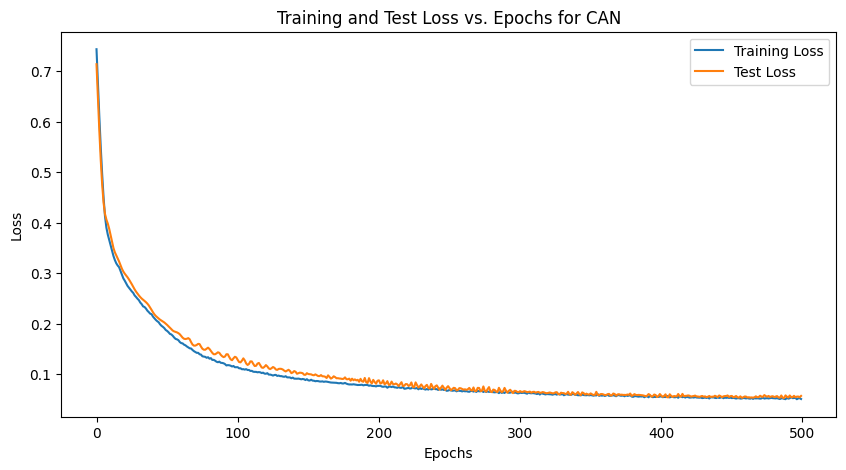

5_percent_accuracy for CAN: 0.3279961183891315


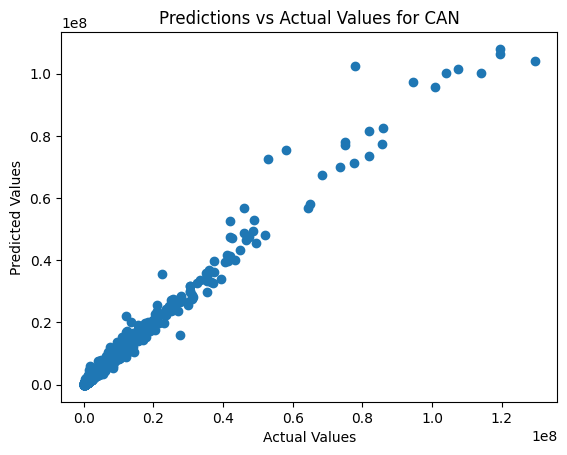

In [5]:
#500 epochs comparison CAN
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=490, hidden_dim1=130, hidden_dim2=39, hidden_dim3=30, dropout_rate=0.28):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']
df['value_eur_2021'] = df['value_eur_2021']
df['value_eur_2022'] = df['value_eur_2022']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
#from pytorch_tabnet.tab_model import TabNetRegressor
#from catboost import CatBoostRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy

# Causal Attention Network for numerical regression
class CausalAttentionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_layers=2, dropout_rate=0.2):
        super(CausalAttentionRegressor, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output layer

    def forward(self, x):
        # Add a batch dimension (for the transformer)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_and_evaluate_CAN(X_train, X_test, y_train, y_test, target_scaler):
    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Initialize the model
    input_dim = X_train.shape[1]
    model = CausalAttentionRegressor(input_dim)

    # Define the loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    # To store losses
    train_losses = []
    test_losses = []

    # Training loop
    epochs = 500
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Save the training loss
        train_losses.append(train_loss.item())

        # Evaluation step
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    # Plot training and test loss vs. epochs
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss vs. Epochs for CAN')
    plt.legend()
    plt.show()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred_scaled = y_pred_tensor.numpy()

    y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

    # Compute custom accuracy
    five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
    print(f'5_percent_accuracy for CAN: {five_percent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs Actual Values for CAN')
    plt.show()

    return model

# Data preparation and training (similar to MLP)
def fifa_pred_CAN(target_column):
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Training and evaluation for CAN
    print("Training and evaluating CAN...")
    train_and_evaluate_CAN(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, target_scaler)

fifa_pred_CAN('value_eur_2022')


<ipython-input-4-39c566324979>:126: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-4-39c566324979>:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating CNNRegressor with best hyperparameters...
Epoch [100/500], Training Loss: 0.0918, Test Loss: 0.1335
Epoch [200/500], Training Loss: 0.0614, Test Loss: 0.1558
Epoch [300/500], Training Loss: 0.0506, Test Loss: 0.0782
Epoch [400/500], Training Loss: 0.0381, Test Loss: 0.1293
Epoch [500/500], Training Loss: 0.0381, Test Loss: 0.1139


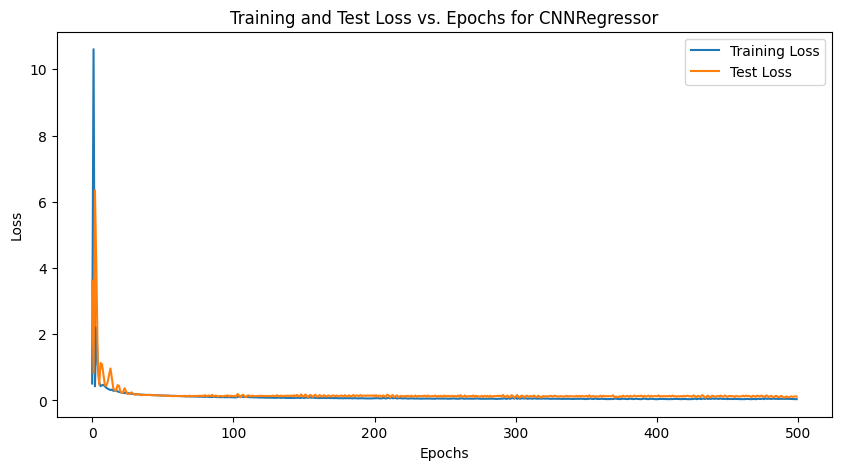

5_percent_accuracy for CNNRegressor: 0.23629306162057254


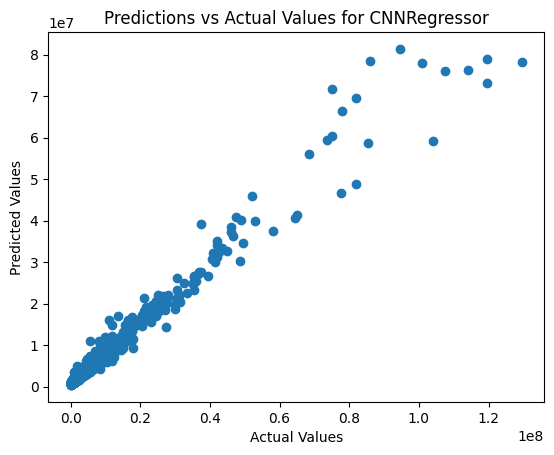

In [ ]:
#500 epochs comparison CNN

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=490, hidden_dim1=130, hidden_dim2=39, hidden_dim3=30, dropout_rate=0.28):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']
df['value_eur_2021'] = df['value_eur_2021']
df['value_eur_2022'] = df['value_eur_2022']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
#from pytorch_tabnet.tab_model import TabNetRegressor
#from catboost import CatBoostRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
class CNNRegressor(nn.Module):
    def __init__(self, input_dim, num_filters=64, kernel_size=3, dropout_rate=0.3):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm1d(num_filters*2)
        self.conv3 = nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=kernel_size, padding=1)
        self.bn3 = nn.BatchNorm1d(num_filters*4)

        self.fc1 = nn.Linear(num_filters*4 * (input_dim // (2**3)), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for a single target variable

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_and_evaluate_cnn(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'CNNRegressor':
        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Initialize the model
        input_dim = X_train.shape[1]
        model = CNNRegressor(input_dim)

        # Define the custom loss function and optimizer
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=7e-5)

        # To store losses
        train_losses = []
        test_losses = []

        # Training loop
        epochs = 500
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            train_loss = criterion(outputs, y_train_tensor)
            train_loss.backward()
            optimizer.step()

            # Save the training loss
            train_losses.append(train_loss.item())

            # Evaluation step
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs, y_test_tensor)
                test_losses.append(test_loss.item())

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

        # Plot training and test loss vs. epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Test Loss vs. Epochs for {model_name}')
        plt.legend()
        plt.show()

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_scaled = y_pred_tensor.numpy()

        y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

        # Compute custom accuracy
        five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
        print(f'5_percent_accuracy for {model_name}: {five_percent_accuracy}')

        # Plot the predicted vs. actual values
        plt.scatter(y_test_original, y_pred)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predictions vs Actual Values for {model_name}')
        plt.show()

    return model

def fifa_pred_with_cnn(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
        'CNNRegressor': {
            # Define any best parameters here if needed
        }
    }

    # Training and evaluation for CNN model
    for model_name in ['CNNRegressor']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate_cnn(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params.get(model_name, {}), target_scaler)

fifa_pred_with_cnn('value_eur_2022')


<ipython-input-7-ac9879a903f1>:114: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-7-ac9879a903f1>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating ImprovedMLP with best hyperparameters...
32
Epoch [100/500], Training Loss: 0.0776, Test Loss: 0.0585
Epoch [200/500], Training Loss: 0.0658, Test Loss: 0.0455
Epoch [300/500], Training Loss: 0.0690, Test Loss: 0.0474
Epoch [400/500], Training Loss: 0.0590, Test Loss: 0.0367
Epoch [500/500], Training Loss: 0.0527, Test Loss: 0.0398


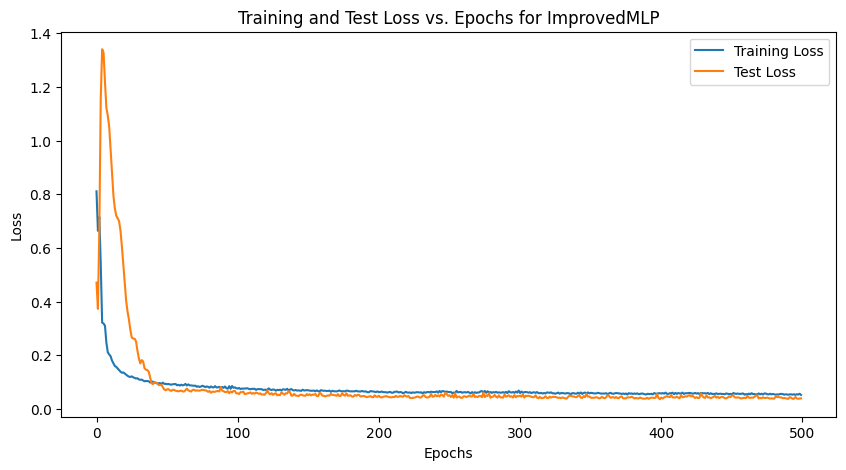

5_percent_accuracy for ImprovedMLP: 0.651140223192625


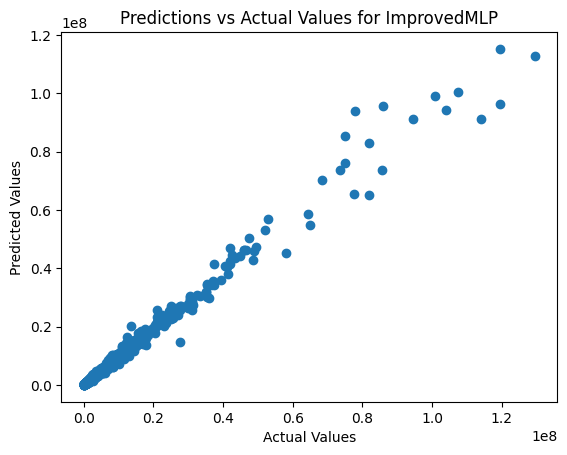

In [7]:
#500 epochs comparison MLP

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=490, hidden_dim1=130, hidden_dim2=39, hidden_dim3=30, dropout_rate=0.28):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']
df['value_eur_2021'] = df['value_eur_2021']
df['value_eur_2022'] = df['value_eur_2022']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=256, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(AdvancedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512,256,128,64], dropout_rate=0.27):
        super(ImprovedMLP, self).__init__()

        print(input_dim)
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LeakyReLU())  # LeakyReLU for improved performance
            layers.append(nn.BatchNorm1d(hidden_dim))  # Batch Normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is 1 - accuracy (custom_accuracy).
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    percentage_diff = torch.abs((y_true - y_pred) / y_true)
    accuracy = torch.mean((percentage_diff <= 0.05).float())
    loss = 1 - accuracy

    return loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        # Calculate MSE loss
        mse_loss = nn.MSELoss(reduction='none')(y_pred, y_true)
        # Apply weights
        weighted_loss = mse_loss * self.weights
        return weighted_loss.mean()


def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler, weights):
    if model_name == 'ImprovedMLP':
        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Initialize the model
        input_dim = X_train.shape[1]
        model = ImprovedMLP(input_dim)

        # Define the custom loss function and optimizer
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=7e-5)

        # To store losses
        train_losses = []
        test_losses = []

        # Training loop
        epochs = 500
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            train_loss = criterion(outputs, y_train_tensor)
            train_loss.backward()
            optimizer.step()

            # Save the training loss
            train_losses.append(train_loss.item())

            # Evaluation step
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs, y_test_tensor)
                test_losses.append(test_loss.item())

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

        # Plot training and test loss vs. epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Test Loss vs. Epochs for {model_name}')
        plt.legend()
        plt.show()

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_scaled = y_pred_tensor.numpy()

        y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

        # Compute custom accuracy
        five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
        print(f'5_percent_accuracy for {model_name}: {five_percent_accuracy}')

        # Plot the predicted vs. actual values
        plt.scatter(y_test_original, y_pred)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predictions vs Actual Values for {model_name}')
        plt.show()

    return model


def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    #study = optuna.create_study(direction='minimize')
    #study.optimize(objective, n_trials=50)
    #best_params = study.best_params
    # Default best parameters
    best_params = {
        'ImprovedMLP': {
            # Define any best parameters here if needed
        }
    }
    #best_params = study.best_params
    weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train])  # Example weights

    # Training and evaluation
    for model_name in ['ImprovedMLP']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params.get(model_name, {}), target_scaler,weights)

fifa_pred('value_eur_2022')




<ipython-input-1-5e5ab857c06c>:114: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-1-5e5ab857c06c>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating ImprovedMLP with best hyperparameters...
32
Epoch [100/3500], Training Loss: 0.1629, Test Loss: 0.1202
Epoch [200/3500], Training Loss: 0.1489, Test Loss: 0.1080
Epoch [300/3500], Training Loss: 0.1392, Test Loss: 0.1034
Epoch [400/3500], Training Loss: 0.1277, Test Loss: 0.1001
Epoch [500/3500], Training Loss: 0.1299, Test Loss: 0.0936
Epoch [600/3500], Training Loss: 0.1188, Test Loss: 0.1020
Epoch [700/3500], Training Loss: 0.1152, Test Loss: 0.0916
Epoch [800/3500], Training Loss: 0.1146, Test Loss: 0.0964
Epoch [900/3500], Training Loss: 0.1024, Test Loss: 0.0901
Epoch [1000/3500], Training Loss: 0.1010, Test Loss: 0.0932
Epoch [1100/3500], Training Loss: 0.0976, Test Loss: 0.0857
Epoch [1200/3500], Training Loss: 0.0971, Test Loss: 0.0918
Epoch [1300/3500], Training Loss: 0.0957, Test Loss: 0.0922
Epoch [1400/3500], Training Loss: 0.0943, Test Loss: 0.1047
Epoch [1500/3500], Training Loss: 0.0904, Test Loss: 0.0896
Epoch [1600/3500], Training Loss: 0.0906,

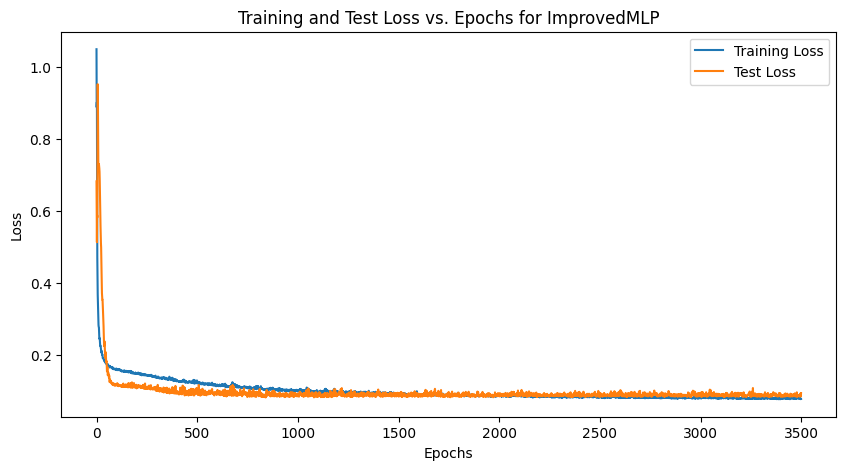

5_percent_accuracy for ImprovedMLP: 0.9121785540999515


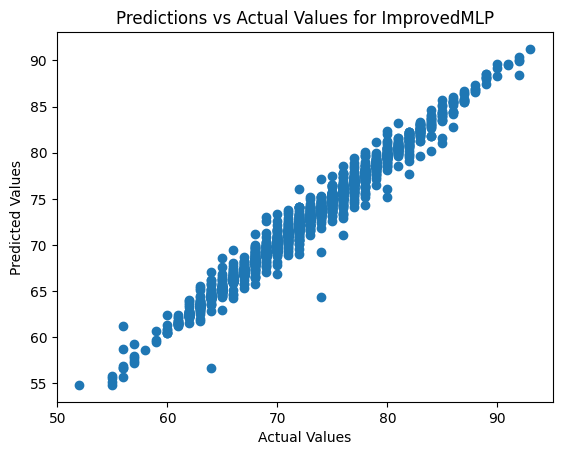

<ipython-input-2-5e5ab857c06c>:114: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-2-5e5ab857c06c>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating ImprovedMLP with best hyperparameters...
32
Epoch [100/3500], Training Loss: 0.1611, Test Loss: 0.1182
Epoch [200/3500], Training Loss: 0.1514, Test Loss: 0.1124
Epoch [300/3500], Training Loss: 0.1438, Test Loss: 0.1013
Epoch [400/3500], Training Loss: 0.1281, Test Loss: 0.0971
Epoch [500/3500], Training Loss: 0.1232, Test Loss: 0.0952
Epoch [600/3500], Training Loss: 0.1180, Test Loss: 0.0872
Epoch [700/3500], Training Loss: 0.1132, Test Loss: 0.0915
Epoch [800/3500], Training Loss: 0.1124, Test Loss: 0.0883
Epoch [900/3500], Training Loss: 0.1060, Test Loss: 0.0849
Epoch [1000/3500], Training Loss: 0.1014, Test Loss: 0.0969
Epoch [1100/3500], Training Loss: 0.0999, Test Loss: 0.0916
Epoch [1200/3500], Training Loss: 0.0992, Test Loss: 0.0909
Epoch [1300/3500], Training Loss: 0.0972, Test Loss: 0.0885
Epoch [1400/3500], Training Loss: 0.0973, Test Loss: 0.0899
Epoch [1500/3500], Training Loss: 0.1002, Test Loss: 0.0888
Epoch [1600/3500], Training Loss: 0.0928,

In [1]:
#3500 epochs MLP Potential

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=490, hidden_dim1=130, hidden_dim2=39, hidden_dim3=30, dropout_rate=0.28):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']
df['value_eur_2021'] = df['value_eur_2021']
df['value_eur_2022'] = df['value_eur_2022']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.02)

    return accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=256, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(AdvancedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512,256,128,64], dropout_rate=0.27):
        super(ImprovedMLP, self).__init__()

        print(input_dim)
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LeakyReLU())  # LeakyReLU for improved performance
            layers.append(nn.BatchNorm1d(hidden_dim))  # Batch Normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is 1 - accuracy (custom_accuracy).
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    percentage_diff = torch.abs((y_true - y_pred) / y_true)
    accuracy = torch.mean((percentage_diff <= 0.05).float())
    loss = 1 - accuracy

    return loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        # Calculate MSE loss
        mse_loss = nn.MSELoss(reduction='none')(y_pred, y_true)
        # Apply weights
        weighted_loss = mse_loss * self.weights
        return weighted_loss.mean()


def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler, weights):
    if model_name == 'ImprovedMLP':
        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Initialize the model
        input_dim = X_train.shape[1]
        model = ImprovedMLP(input_dim)

        # Define the custom loss function and optimizer
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=7e-5)

        # To store losses
        train_losses = []
        test_losses = []

        # Training loop
        epochs = 3500
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            train_loss = criterion(outputs, y_train_tensor)
            train_loss.backward()
            optimizer.step()

            # Save the training loss
            train_losses.append(train_loss.item())

            # Evaluation step
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs, y_test_tensor)
                test_losses.append(test_loss.item())

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

        # Plot training and test loss vs. epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Test Loss vs. Epochs for {model_name}')
        plt.legend()
        plt.show()

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_scaled = y_pred_tensor.numpy()

        y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

        # Compute custom accuracy
        five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
        print(f'5_percent_accuracy for {model_name}: {five_percent_accuracy}')

        # Plot the predicted vs. actual values
        plt.scatter(y_test_original, y_pred)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predictions vs Actual Values for {model_name}')
        plt.show()

    return model


def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    #study = optuna.create_study(direction='minimize')
    #study.optimize(objective, n_trials=50)
    #best_params = study.best_params
    # Default best parameters
    best_params = {
        'ImprovedMLP': {
            # Define any best parameters here if needed
        }
    }
    #best_params = study.best_params
    weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train])  # Example weights

    # Training and evaluation
    for model_name in ['ImprovedMLP']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params.get(model_name, {}), target_scaler,weights)

fifa_pred('potential_2022')




<ipython-input-78-74a8eeb5d07f>:114: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-78-74a8eeb5d07f>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating ImprovedMLP with best hyperparameters...
32
Epoch [100/3500], Training Loss: 0.0738, Test Loss: 0.0558
Epoch [200/3500], Training Loss: 0.0635, Test Loss: 0.0457
Epoch [300/3500], Training Loss: 0.0564, Test Loss: 0.0422
Epoch [400/3500], Training Loss: 0.0543, Test Loss: 0.0403
Epoch [500/3500], Training Loss: 0.0541, Test Loss: 0.0447
Epoch [600/3500], Training Loss: 0.0514, Test Loss: 0.0387
Epoch [700/3500], Training Loss: 0.0489, Test Loss: 0.0373
Epoch [800/3500], Training Loss: 0.0502, Test Loss: 0.0386
Epoch [900/3500], Training Loss: 0.0470, Test Loss: 0.0359
Epoch [1000/3500], Training Loss: 0.0486, Test Loss: 0.0356
Epoch [1100/3500], Training Loss: 0.0453, Test Loss: 0.0397
Epoch [1200/3500], Training Loss: 0.0476, Test Loss: 0.0384
Epoch [1300/3500], Training Loss: 0.0449, Test Loss: 0.0370
Epoch [1400/3500], Training Loss: 0.0447, Test Loss: 0.0610
Epoch [1500/3500], Training Loss: 0.0474, Test Loss: 0.0370
Epoch [1600/3500], Training Loss: 0.0466,

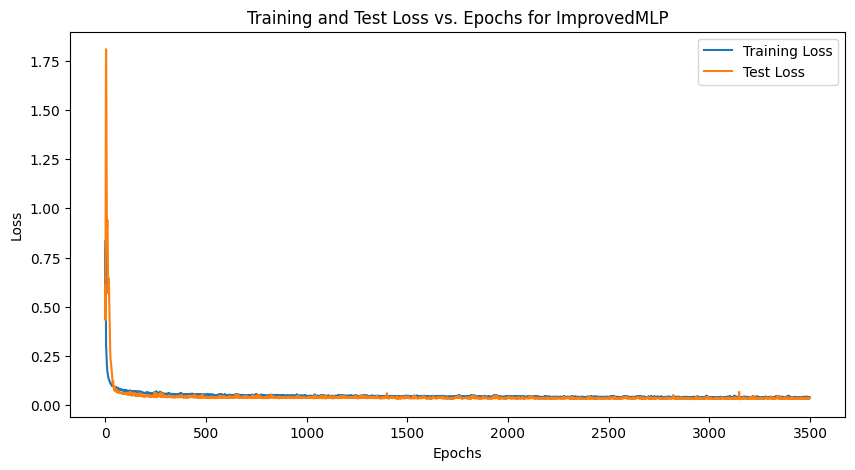

5_percent_accuracy for ImprovedMLP: 0.7486656962639495


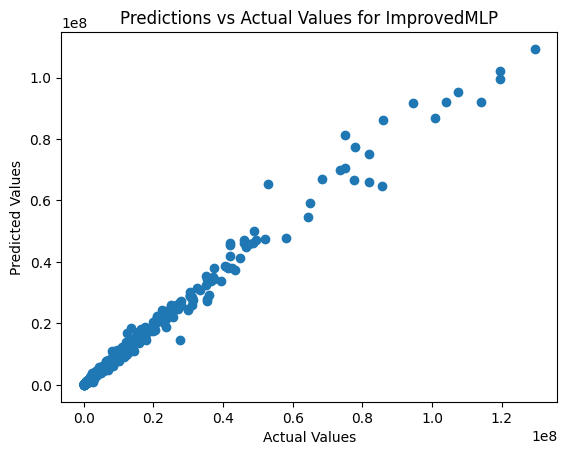

In [ ]:
#3500 epochs MLP Market Value
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=490, hidden_dim1=130, hidden_dim2=39, hidden_dim3=30, dropout_rate=0.28):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x





#In this cell we can the the comparison between models for player value
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets

df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [

    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']
df['value_eur_2021'] = df['value_eur_2021']
df['value_eur_2022'] = df['value_eur_2022']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim0=256, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(AdvancedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim0)
        self.bn1 = nn.BatchNorm1d(hidden_dim0)
        self.fc2 = nn.Linear(hidden_dim0, hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn4 = nn.BatchNorm1d(hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, 1)  # Output layer for a single target variable
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512,256,128,64], dropout_rate=0.27):
        super(ImprovedMLP, self).__init__()

        print(input_dim)
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LeakyReLU())  # LeakyReLU for improved performance
            layers.append(nn.BatchNorm1d(hidden_dim))  # Batch Normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is 1 - accuracy (custom_accuracy).
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    percentage_diff = torch.abs((y_true - y_pred) / y_true)
    accuracy = torch.mean((percentage_diff <= 0.05).float())
    loss = 1 - accuracy

    return loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        # Calculate MSE loss
        mse_loss = nn.MSELoss(reduction='none')(y_pred, y_true)
        # Apply weights
        weighted_loss = mse_loss * self.weights
        return weighted_loss.mean()


def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler, weights):
    if model_name == 'ImprovedMLP':
        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Initialize the model
        input_dim = X_train.shape[1]
        model = ImprovedMLP(input_dim)

        # Define the custom loss function and optimizer
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=7e-5)

        # To store losses
        train_losses = []
        test_losses = []

        # Training loop
        epochs = 3500
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            train_loss = criterion(outputs, y_train_tensor)
            train_loss.backward()
            optimizer.step()

            # Save the training loss
            train_losses.append(train_loss.item())

            # Evaluation step
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs, y_test_tensor)
                test_losses.append(test_loss.item())

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

        # Plot training and test loss vs. epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Test Loss vs. Epochs for {model_name}')
        plt.legend()
        plt.show()

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred_tensor = model(X_test_tensor)
            y_pred_scaled = y_pred_tensor.numpy()

        y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
        y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

        # Compute custom accuracy
        five_percent_accuracy = custom_accuracy(y_test_original, y_pred)
        print(f'5_percent_accuracy for {model_name}: {five_percent_accuracy}')

        # Plot the predicted vs. actual values
        plt.scatter(y_test_original, y_pred)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predictions vs Actual Values for {model_name}')
        plt.show()

    return model


def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    #study = optuna.create_study(direction='minimize')
    #study.optimize(objective, n_trials=50)
    #best_params = study.best_params
    # Default best parameters
    best_params = {
        'ImprovedMLP': {
            # Define any best parameters here if needed
        }
    }
    #best_params = study.best_params
    weights = torch.tensor([1.0 if value < 50 else 10.0 for value in y_train])  # Example weights

    # Training and evaluation
    for model_name in ['ImprovedMLP']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params.get(model_name, {}), target_scaler,weights)

fifa_pred('value_eur_2022')


